# Compute Event Coordinate System

This Jupyter notebook can be used to compute the Event Coordinate System (ECS) for 



## Evironment Setup

In [1]:
#load libraries
library(tidyverse)
library(plyr)
library(assertthat)
library(pracma)
#plotting libraries
library(ggplot2)
library(ggmap)
#user written functions
source(file.path('R_lib','ecs_functions.R'))
ANDarray <- function (...)  Reduce("&", list(...))

#set plotting preferences
theme_set(theme_linedraw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘assertthat’



### Input file names

In [2]:
#filenames
fname_flatfile_rup    <- file.path('..','Data','flatfiles','ruptures_for_greg.csv')
fname_flatfile_disp   <- file.path('..','Data','flatfiles','pts_for_greg.csv')
fname_flatfile_prerup <- NULL
#flag produce flatfile
flag_flatfile <- FALSE

### ECS parameters

In [3]:
#slip rank to use in ECS calcs
rank2consider <- c('Total','Principal','Cumulative')
#weighting options
lambda_p <- 0.05 #penarly on smoothness
wt_disp_min <- 0.05 #minimum allowed disp value
#rupture weighting options
# flag_wt_rup_opt
#   1: assign relative weights to rupture points based on min slip factored by relv_wt_rup2disp
#   2: assign absolute weights to rupture points based on abs_wt_rup
flag_wt_rup_opt <- 2
#relv_wt_rup2disp <- 0.5
abs_wt_rup <- 0.05
#scale weights by rupture length 
flag_wt_rup_len <- TRUE
#normalize rupture weights by the relative number of disp points and rup vertices
flag_norm_disp_rup_wt <- FALSE
#maximum weighting ratio value
r_thres_max <- 1e4

#displacement field for weights
field_disp_wt <- 'recommended_net_preferred_for_analysis_meters'

### Output Directory

In [4]:
#create output directory
dir_ecs_data <- file.path('..','Data','ecs','data')
dir_ecs_figs <- file.path('..','Data','ecs','figures')
dir.create(file.path(dir_ecs_data), showWarnings = FALSE, recursive=TRUE)
dir.create(file.path(dir_ecs_figs), showWarnings = FALSE, recursive=TRUE)

## Read Data

In [5]:
#read displacement and rupture faltfiles
flatfile_rup <- read.csv(fname_flatfile_rup,header = TRUE, sep = ",")
flatfile_disp <- read.csv(fname_flatfile_disp,header = TRUE, sep = ",")
if(!is.null(fname_flatfile_prerup)) flatfile_prerup <- read.csv(fname_flatfile_prerup,header = TRUE, sep = ",")
colnames(flatfile_rup)[colnames(flatfile_rup) == "longitude_degrees"] <- "Longitude"
colnames(flatfile_rup)[colnames(flatfile_rup) == "latitude_degrees"]  <- "Latitude"
colnames(flatfile_disp)[colnames(flatfile_disp) == "longitude_degrees"] <- "Longitude"
colnames(flatfile_disp)[colnames(flatfile_disp) == "latitude_degrees"]  <- "Latitude"
if(!is.null(fname_flatfile_prerup)){
    colnames(flatfile_prerup)[colnames(flatfile_prerup) == "longitude_degrees"] <- "Longitude"
    colnames(flatfile_prerup)[colnames(flatfile_prerup) == "latitude_degrees"]  <- "Latitude"
} 

#number of earthquakes
eqid_array <- unique(flatfile_rup$EQ_ID)
n_eq<- length(eqid_array)

## Compute ECS Data

Event 1 of 2 ...

Event Name: HomesteadValley

Event ID: 70

Event Style: Strike-Slip

Group id: 70_01

Disp field for wt: recommended_net_preferred_for_analysis_meters

Num disp pt: 4

Num rup pt: 91

Num of ecs pt: 3296

Calculating ECS

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

...

Event 2 of 2 ...

Event Name: Killari

Event ID: 74

Event Style: Reverse

Group id: 74_01

Disp field for wt: recommended_net_preferred_for_analysis_meters

Num disp pt: 10

Num rup pt: 48

Num of ecs pt: 121

Calculating ECS



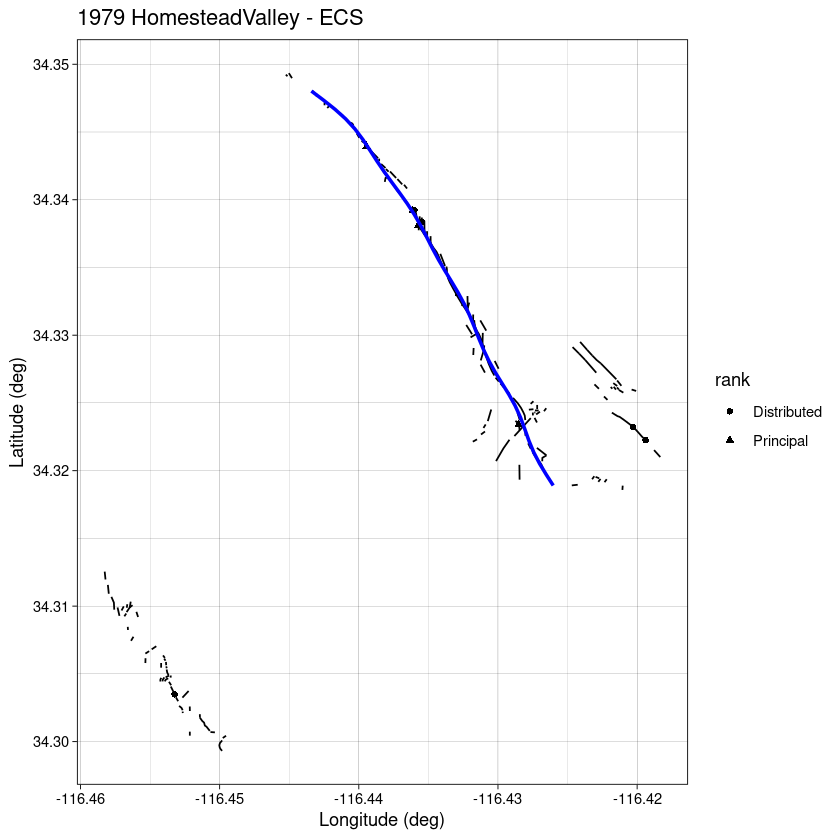

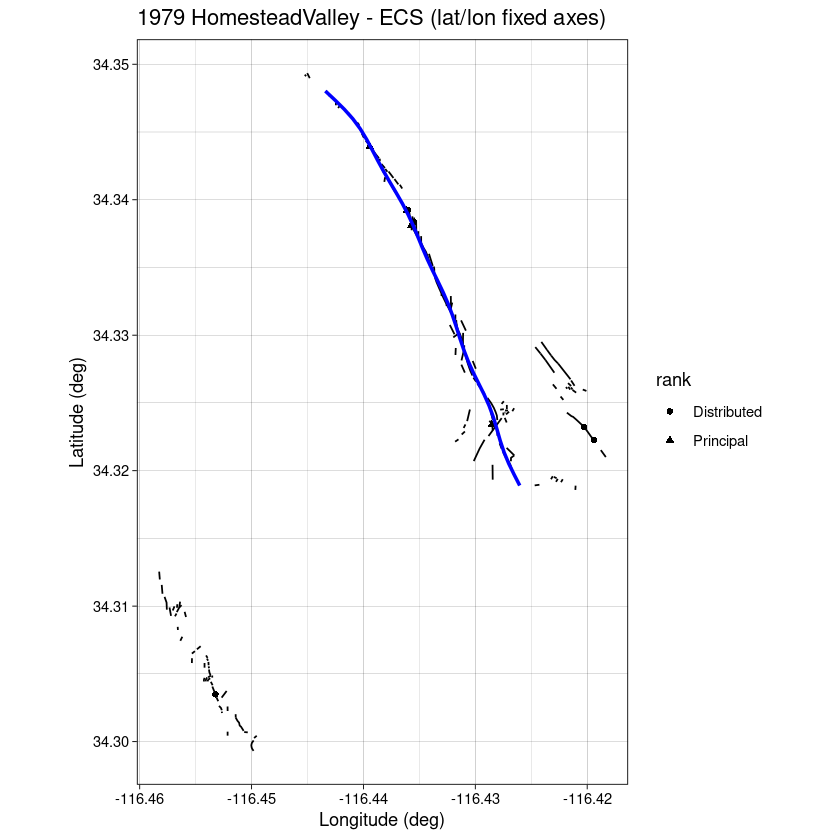

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

...



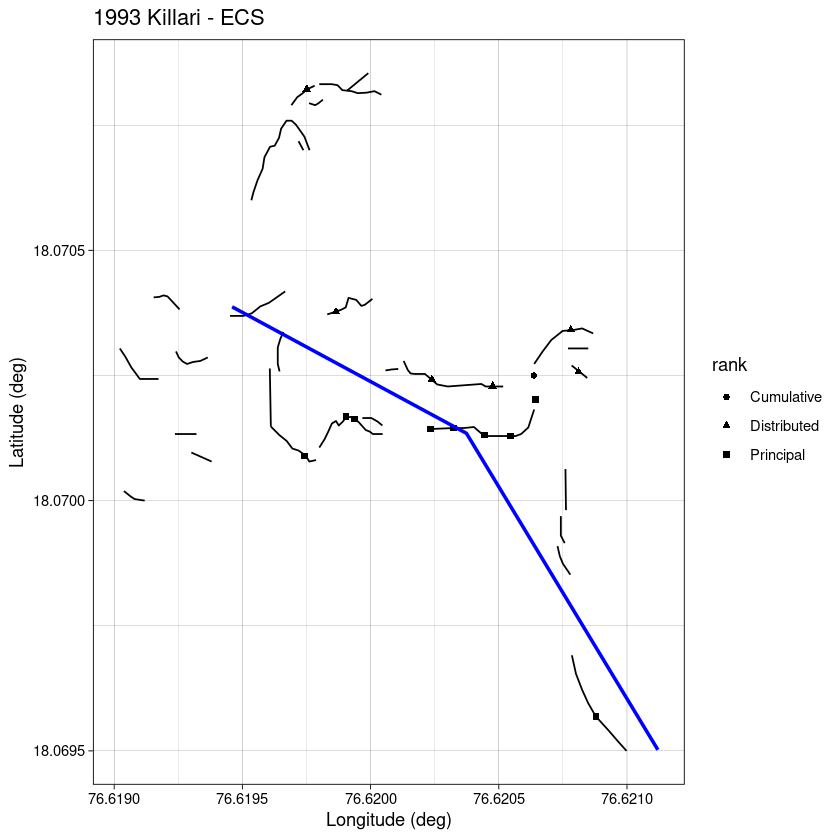

ECS calculations completed.



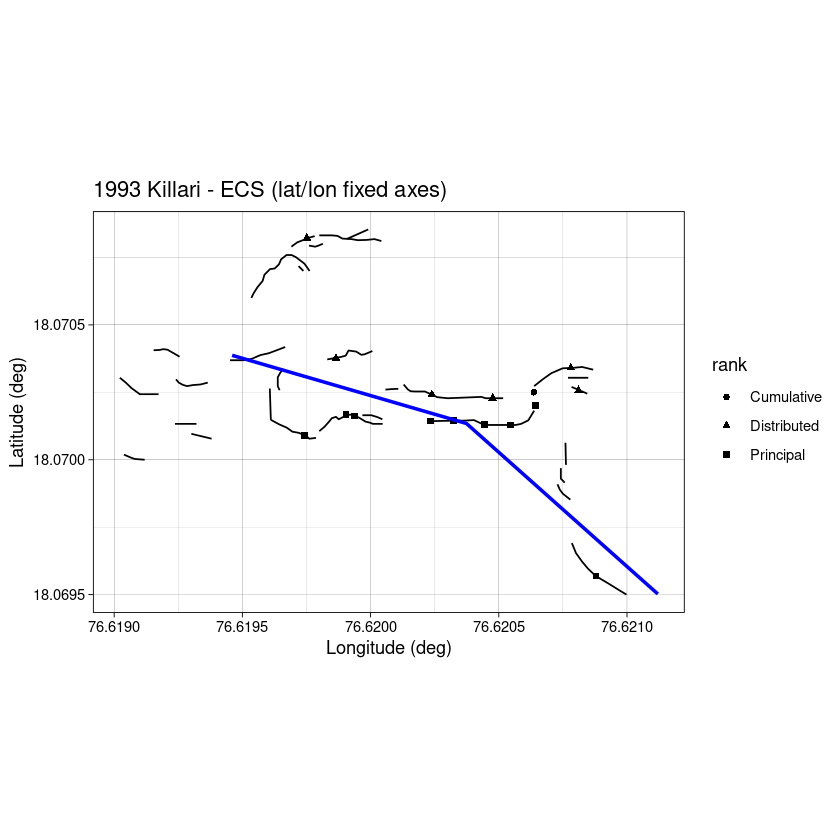

In [6]:
#iterate compute the nominal trace for each event
for (k in seq(n_eq)){
    # Event Data
    #--------------------
    #displacement points
    fault_disp_all <- subset(flatfile_disp, EQ_ID==eqid_array[k])
    #rupture data
    fault_rup_all  <- subset(flatfile_rup, EQ_ID==eqid_array[k])
    #prerupture data
    if(!is.null(fname_flatfile_prerup)){
        fault_prerup_all  <- subset(flatfile_prerup, EQ_ID==eqid_array[k])
    } else {
        fault_prerup_all <- data.frame()
    }

    #event info
    eq_id     <- unique(fault_disp_all$EQ_ID)
    eq_name   <- unique(fault_disp_all$eq_name)
    eq_style  <- unique(fault_disp_all$style)
    eq_date   <- parse_datetime( unique(fault_disp_all$eq_date), "'%Y-%m-%d'") 
    eq_year   <- format(eq_date, format = "%Y")
    pt_ds_id  <- unique(fault_disp_all$PT_DS_ID)
    rup_ds_id <- unique(fault_rup_all$RUP_DS_ID)
    group_id  <- unique(fault_disp_all$group_id)
    assert_that(length(group_id)==1)
    #output filename
    file_name2save <- sprintf('%s_%s_group_id_%s',eq_year,eq_name,group_id)

    #print event info
    message("Event ",k," of ",n_eq," ...")
    message("Event Name: ",  eq_name)
    message("Event ID: ",    eq_id)
    message("Event Style: ", eq_style)
    message("Group id: ",    group_id)

    # Remove outliers
    #--------------------
    i_outliers_d <- fault_disp_all[,field_disp_wt] < -900
    i_outliers_r <- rep(FALSE, nrow(fault_rup_all))
    fault_disp <- fault_disp_all[!i_outliers_d, ]
    fault_rup  <- fault_rup_all[!i_outliers_r, ]

    # Combine dataset for ECS calculation
    #--------------------
    #displacement weights
    # ---  ---  ---  ---
    wt_array_disp <- abs( fault_disp[,field_disp_wt] )
    i_disp2keep <- (!is.na(wt_array_disp)) & (fault_disp$rank %in% rank2consider)
    wt_array_disp <- wt_array_disp[i_disp2keep]
    wt_array_disp[wt_array_disp < wt_disp_min] <- wt_disp_min #adjust minimum weight
    mean_wt_array_disp <- mean(wt_array_disp, na.rm = TRUE)
    min_wt_array_disp  <- min(wt_array_disp, na.rm = TRUE)
    #rupture weights
    # ---  ---  ---  ---
    #rupture weight options
    if(flag_wt_rup_opt == 1){
        #relative to displacement weights
        wt_array_rup <- array(min_wt_array_disp * relv_wt_rup2disp, dim = nrow(fault_rup))
    } else if(flag_wt_rup_opt == 2){
        #absolute weights
        wt_array_rup <- array(abs_wt_rup, dim = nrow(fault_rup))
    }
    #rupture length weights
    wt_array_ruplen <- array(dim = nrow(fault_rup)) 
    for ( r_id in unique(fault_rup$RUP_ID) ){
        i_rup <- fault_rup$RUP_ID == r_id
        seg_rup <- fault_rup[i_rup,c('Longitude','Latitude','RUP_ID','NODE_ID')]
        seg_len <- rup_length(seg_rup)
        wt_array_ruplen[i_rup] <- seg_len / sum(i_rup)
    }
    #combined weights
    if (flag_wt_rup_len == TRUE){
        wt_array_rup <- wt_array_rup * wt_array_ruplen    
    }
    i_rup2keep <- (!is.na(wt_array_rup)) & (fault_rup$rank %in% rank2consider)
    wt_array_rup <- wt_array_rup[i_rup2keep]
    #normalize rupture weights by relative number of displacement and rupture points
    if (flag_norm_disp_rup_wt == TRUE){
        wt_array_rup <- wt_array_rup * sum(i_disp2keep) / sum(i_rup2keep)
    }
    #normalize disp and rup weights
    # ---  ---  ---  ---
    min_wt <- min(min(wt_array_rup),min(wt_array_disp))
    wt_array_disp <- round(wt_array_disp/min_wt)
    wt_array_rup <- round(wt_array_rup/min_wt)

    #data-set for calculation of ref. line
    #displacement data-set
    data4ecs1 <- fault_disp[i_disp2keep,c('Longitude','Latitude')] 
    data4ecs1$wt <- wt_array_disp #assign disp. weights
    #rupture data-set
    data4ecs2 <- fault_rup[i_rup2keep,c('Longitude','Latitude','RUP_ID','NODE_ID')]
    data4ecs2$wt <- wt_array_rup #assign rupture weights
    #combined data for ECS 
    data4ecs <- rbind.fill(data4ecs1, data4ecs2)

    #Developed weighted dataset
    #--------------------
    data4ecs_wt <- weight_ecs_data(data4ecs, ratio_thres=r_thres_max)

    #print data-set info
    message("Disp field for wt: ", field_disp_wt)
    message("Num disp pt: ",       nrow(data4ecs1))
    message("Num rup pt: ",        nrow(data4ecs2))
    message("Num of ecs pt: ",     nrow(data4ecs_wt))

    # Compute ECS
    #--------------------
    message("Calculating ECS")
    out <- ecs_main(data4ecs_wt, lamb_spline  = lambda_p, calc_xy = TRUE)

    #event coordinate system
    ecs_trace <- out[[1]]
    #add earthquake info in reference trace data frame
    ecs_trace$EQ_ID <- eq_id
    ecs_trace$eq_name <- eq_name
    ecs_trace <- ecs_trace[c('EQ_ID','eq_name','REF_ID','Longitude','Latitude','x','y','u','t','curv')]
    names(ecs_trace)[names(ecs_trace) == 'u']    <- 'ecs_u'
    names(ecs_trace)[names(ecs_trace) == 't']    <- 'ecs_t'
    names(ecs_trace)[names(ecs_trace) == 'curv'] <- 'ecs_curv'
    ecs_trace = subset(ecs_trace, select = -c(x,y))

    #compute GC2 coordinates of disp. points
    fault_disp_all_ecs   <- latlon2reftrace(fault_disp_all, ecs_trace)
    fault_disp_all$ecs_u    <- fault_disp_all_ecs$u 
    fault_disp_all$ecs_t    <- fault_disp_all_ecs$t
    fault_disp_all$ecs_curv <- fault_disp_all_ecs$curv

    #compute GC2 coordinates of rupture vertices
    fault_rup_all_ecs   <- latlon2reftrace(fault_rup_all, ecs_trace)
    fault_rup_all$ecs_u    <- fault_rup_all_ecs$u 
    fault_rup_all$ecs_t    <- fault_rup_all_ecs$t
    fault_rup_all$ecs_curv <- fault_rup_all_ecs$curv
  
    #compute GC2 coordinates of prerupture vertices
    if (nrow(fault_prerup_all) >= 1){
        fault_prerup_all_ecs   <- latlon2reftrace(fault_prerup_all, ecs_trace)
        fault_prerup_all$ecs_u    <- fault_prerup_all_ecs$u 
        fault_prerup_all$ecs_t    <- fault_prerup_all_ecs$t
        fault_prerup_all$ecs_curv <- fault_prerup_all_ecs$curv
    }
  
    # Create ECS plots
    #--------------------
    #plot ecs trace
    p_eq <- ggplot() +
        geom_point(data = fault_disp, aes(x = Longitude, y = Latitude, shape = rank )) +
        geom_path(data = fault_rup, aes(x = Longitude, y = Latitude, group =  RUP_ID), 
                  size = 0.5, color = "black") +
        geom_path(data = ecs_trace, aes(x = Longitude, y = Latitude ), 
                  color = "blue", size = 1) +
        geom_point(data = fault_disp_all[i_outliers_r, ], aes(x = Longitude, y = Latitude ), color = "red") +
        geom_path(data = fault_disp_all[i_outliers_r, ],  aes(x = Longitude, y = Latitude, group =  RUP_ID), 
                  size = 0.5, color = "red")
    if (nrow(fault_prerup_all) >= 1){
        p_eq <- p_eq + geom_path(data = fault_rup, aes(x = Longitude, y = Latitude, group =  RUP_ID), 
                                 size = 0.5, color = "black")
    }
    p_eq <- p_eq + xlab('Longitude (deg)') + ylab('Latitude (deg)') + 
                   labs(title=sprintf('%s %s - ECS',eq_year, eq_name))
    print(p_eq)
    #same figure with equal axes  
    p_eq_aratio1 <- p_eq + coord_quickmap() + 
                           labs(title=sprintf('%s %s - ECS (lat/lon fixed axes)',eq_year, eq_name))
    print(p_eq_aratio1)

    #save original figure
    fname_fig = file.path(dir_ecs_figs,paste0(file_name2save,'_ecs_trc.png')) 
    ggsave(filename = fname_fig, plot = p_eq, device = "png")
    #save figure with equal axes
    fname_fig = file.path(dir_ecs_figs,paste0(file_name2save,'_ecs_trc_eqax.png')) 
    ggsave(filename = fname_fig, plot = p_eq_aratio1, device = "png")
  
    # Save ECS data
    #--------------------
    #revert lat lon fields to original names and keep only relevant fields
    fault_disp_all <- fault_disp_all[c('EQ_ID','eq_name','PT_DS_ID','PT_ID','MEAS_ID',
                                       'rank','group_id','location_id',
                                       'Longitude','Latitude','ecs_u','ecs_t','ecs_curv')]
    colnames(fault_disp_all) [names(fault_disp_all) %in% c('Longitude','Latitude')] <- 
                                                         c('longitude_degrees','latitude_degrees')
    fault_rup_all <- fault_rup_all[c('EQ_ID','eq_name','RUP_DS_ID','RUP_ID','NODE_ID','rank',
                                     'Longitude','Latitude','ecs_u','ecs_t','ecs_curv')]
    colnames(fault_rup_all) [names(fault_rup_all) %in% c('Longitude','Latitude')] <- 
                                                       c('longitude_degrees','latitude_degrees')
    if (nrow(fault_prerup_all) >= 1){
        fault_prerup_all <- fault_prerup_all[c('EQ_ID','eq_name','PRUP_DS_ID','PRUP_ID','PNODE_ID',
                                               'Longitude','Latitude','ecs_u','ecs_t','ecs_curv')]
        colnames(fault_prerup_all) [names(fault_prerup_all) %in% c('Longitude','Latitude')] <- 
                                                                 c('longitude_degrees','latitude_degrees')
    }
  
    #save processed data in csv
    write.csv(ecs_trace,  file = file.path(dir_ecs_data, paste0(file_name2save,'_ecs_data.csv')), 
              row.names=FALSE)
    write.csv(fault_rup_all,  file = file.path(dir_ecs_data, paste0(file_name2save,'_rup_data.csv')),  
              row.names=FALSE)
    write.csv(fault_disp_all, file = file.path(dir_ecs_data, paste0(file_name2save,'_disp_data.csv')), 
              row.names=FALSE)
    if (nrow(fault_prerup_all) >= 1)
        write.csv(fault_prerup_all,  file = file.path(dir_data_ecs, paste0(file_name2save,'_prerup_data.csv')),  
                  row.names=FALSE)

    message("...")
}
message("ECS calculations completed.")